In [1]:
import os
import argparse
import pandas as pd
import tensorflow as tf
from bp import Environment
import TransUnet.experiments.config as conf
from dTurk.utils.clr_callback import CyclicLR
import TransUnet.models.transunet as transunet
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from train_helpers import dice_loss, mean_iou, oversampling, create_dataset

Segmentation Models: using `tf.keras` framework.


In [2]:
import dTurk.models.sm_models as sm
from dTurk.models.SM_UNet import SM_UNet_Builder

In [3]:
env = Environment()

In [4]:
dataset = "MACH-77-it1"
machine = "local"
monitor = "val_loss"
epochs = 5
patience = 12
batch_size = 32
lr = 0.005
train_augmentation_file = "/Users/srinathramalingam/Desktop/codebase/dTurk/dTurk/augmentation/configs/light.yaml"
save_path = "weights/U1"
checkpoint_filepath = save_path + "/checkpoint/"

In [5]:
dataset_directory = os.environ.get("BP_PATH_REMOTE") + "/datasets/semseg_base" + "/" + dataset

In [6]:
try:
    gpus = tf.config.list_physical_devices("GPU")
    tf.config.set_visible_devices(gpus[args_dict["gpu"]], "GPU")
except:
    print("Gpus not found")

Gpus not found


In [7]:
train_input_names = [
    dataset_directory + "/train_labels/" + i
    for i in os.listdir(dataset_directory + "/train_labels/")
    if i.endswith(".png")
]
val_input_names = [
    dataset_directory + "/val/" + i for i in os.listdir(dataset_directory + "/val/") if i.endswith(".png")
]

In [8]:
train_input_names = oversampling(train_input_names, machine, dataset, -1)
train_ds_batched, val_ds_batched = create_dataset(train_input_names, val_input_names, train_augmentation=train_augmentation_file)

100%|█████████████████████████████████████████████| 3000/3000 [00:10<00:00, 280.39it/s]
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/srinathramalingam/opt/anaconda3/envs/bv2/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
2022-07-07 09:22:10.086047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
step_size = int(2.0 * len(train_input_names) / batch_size)

In [10]:
builder = SM_UNet_Builder(
    encoder_name='efficientnetv2-l',
    input_shape=(256, 256, 3),
    num_classes=3,
    activation="softmax",
    train_encoder=False,
    encoder_weights="imagenet",
    decoder_block_type="upsampling",
    head_dropout=0,  # dropout at head
    dropout=0,  # dropout at feature extraction
)

In [11]:
model = builder.build_model()

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [12]:
model.compile(optimizer="adam", loss=dice_loss, metrics=mean_iou)

In [13]:
callbacks = []
cyclic_lr = CyclicLR(
    base_lr=lr / 10.0,
    max_lr=lr,
    step_size=step_size,
    mode="triangular2",
    cyclic_momentum=False,
    max_momentum=False,
    base_momentum=0.8,
)
callbacks.append(cyclic_lr)

early_stopping = EarlyStopping(
    monitor=monitor,
    mode="min" if "loss" in monitor else "max",
    patience=patience,
    verbose=1,
    restore_best_weights=True,
)
callbacks.append(early_stopping)

In [14]:
history = model.fit(
    train_ds_batched, epochs=epochs, validation_data=val_ds_batched, callbacks=[callbacks]
)

Epoch 1/5
498/498 [==============================] - 15223s 30s/step - loss: 0.4707 - mean_iou: 0.9680 - val_loss: 0.4649 - val_mean_iou: 0.9983
Epoch 2/5
498/498 [==============================] - 11745s 24s/step - loss: 0.4667 - mean_iou: 0.9822 - val_loss: 0.4648 - val_mean_iou: 0.9990
Epoch 3/5
484/498 [============================>.] - ETA: 5:31 - loss: 0.4667 - mean_iou: 0.9827

KeyboardInterrupt: 

1/1 [==============================] - 0s 319ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


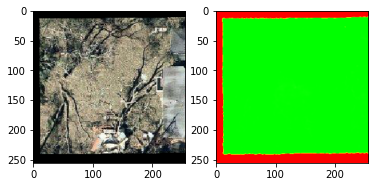

1/1 [==============================] - 0s 313ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


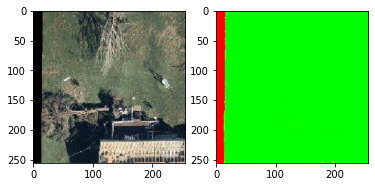

1/1 [==============================] - 0s 333ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


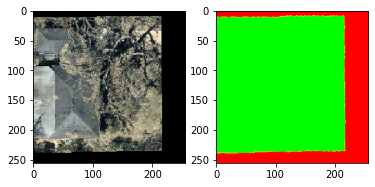

1/1 [==============================] - 0s 354ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


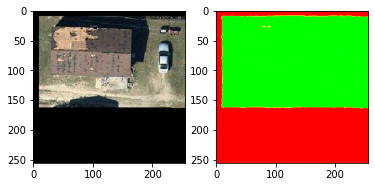

1/1 [==============================] - 0s 371ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


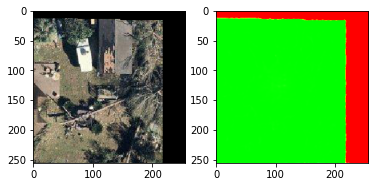

1/1 [==============================] - 0s 388ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


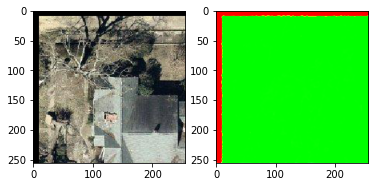

1/1 [==============================] - 0s 419ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


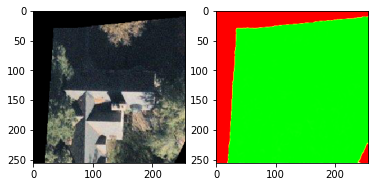

1/1 [==============================] - 0s 417ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


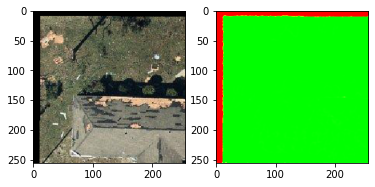

1/1 [==============================] - 0s 432ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


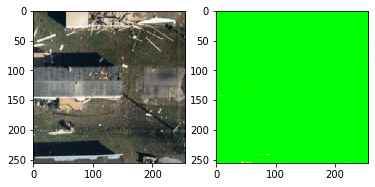

1/1 [==============================] - 0s 431ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


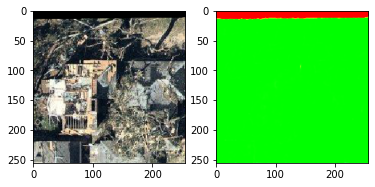

1/1 [==============================] - 0s 419ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


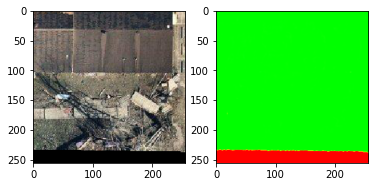

1/1 [==============================] - 0s 423ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


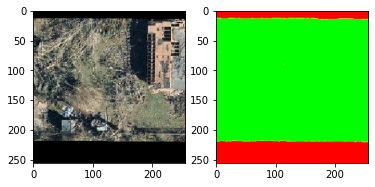

1/1 [==============================] - 0s 431ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


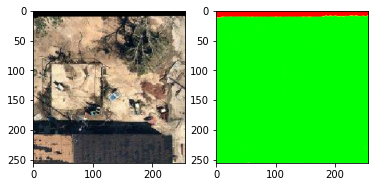

1/1 [==============================] - 0s 440ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


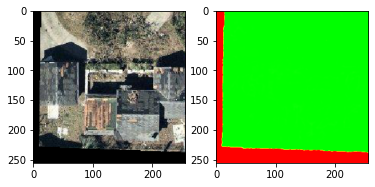

1/1 [==============================] - 0s 442ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


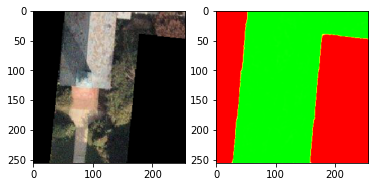

1/1 [==============================] - 0s 446ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


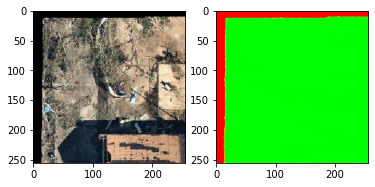

1/1 [==============================] - 0s 434ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


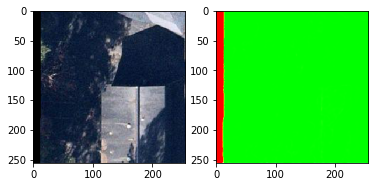

1/1 [==============================] - 0s 441ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


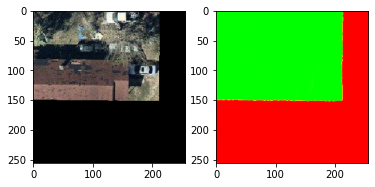

1/1 [==============================] - 0s 441ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


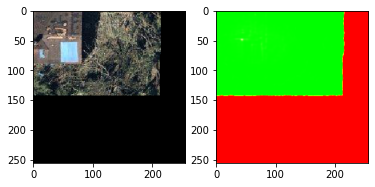

1/1 [==============================] - 0s 457ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


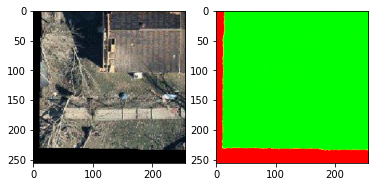

1/1 [==============================] - 0s 486ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


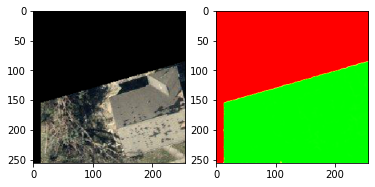

1/1 [==============================] - 0s 469ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


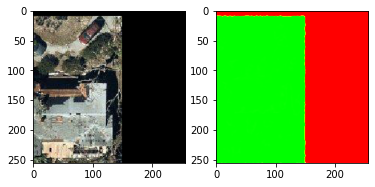

1/1 [==============================] - 0s 487ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


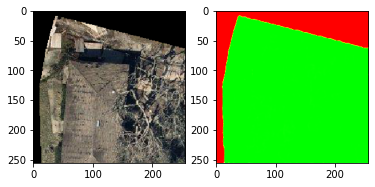

1/1 [==============================] - 0s 476ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


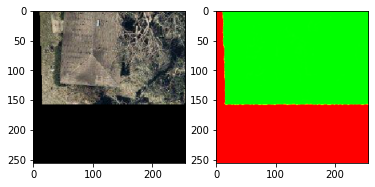

1/1 [==============================] - 1s 512ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


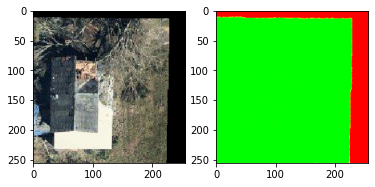

1/1 [==============================] - 0s 489ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


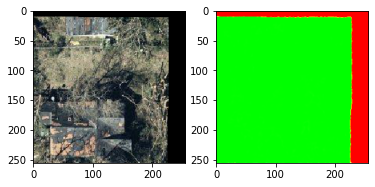

1/1 [==============================] - 0s 459ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


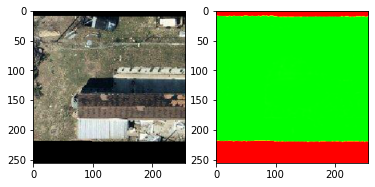

1/1 [==============================] - 0s 475ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


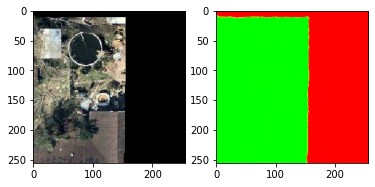

1/1 [==============================] - 0s 471ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


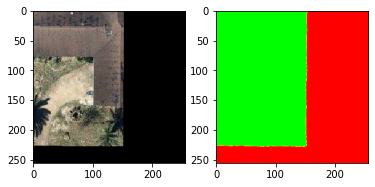

1/1 [==============================] - 0s 469ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


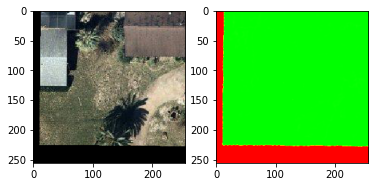

In [17]:
val_input_names = ["/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images/" + i for i in os.listdir("/Users/srinathramalingam/Desktop/codebase/Jupyter_predictions_Nearspace/MACH-77-it2/val/images")]

import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict(image, model,):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.array(img)/255
    img = img.reshape((1,256,256,3))
    prediction = model.predict(img)
    prediction = tf.clip_by_value(prediction, 0.0, 1.0)
    pred = prediction * 255
    pred = np.array(pred).reshape((256,256,3))
    img = img.reshape((256,256,3))
    return img, pred


for file in range(len(val_input_names)):
    img, pred1 = predict(val_input_names[file], model)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(pred1)

    plt.show()

In [ ]:
iou = history.history["mean_iou"]
val_iou = history.history["val_mean_iou"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

df = pd.DataFrame(iou)
df.columns = ["mean_iou"]
df["val_mean_iou"] = val_iou
df["loss"] = loss
df["val_loss"] = val_loss

df.to_csv("U1-logs.csv")

In [ ]:
network.model.load_weights(checkpoint_filepath)
saved_model_path = args_dict["save_path"] + "/model"
network.model.save(saved_model_path)